In [1]:
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")

I will be trying to use the open price, the high of the day, the low of the day and the closing price to predict what the value of the stock will be the next day. The data has a date-time index and I think it will allow me to easly index and slice the data to prep it for ML. I also decided to remove old data as it may not be very signoficant to the prediction of todays market (the world has changed a lot!!). I am using a random forest classifier to train my model. I like random forest because of the way it uses trains a bunch of individual decision trees with randomized parameters and then averaging the results (making it resistent to overfitting). They can also pick up non-linear trends in data (which is most of the things we want to predict these days).

<Axes: xlabel='Date'>

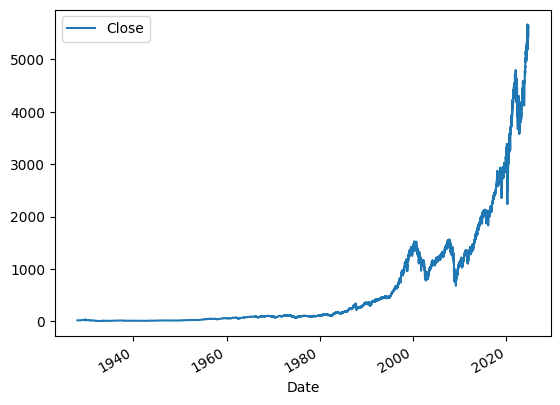

In [3]:
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500.plot.line(y="Close", use_index=True)

I will be setting my target for the ML to be "will the price go up or down". I will not be trying to predict the absolute value of the stock. Instead, I just want to know weather the price will be going up or down the next day. With time series data we must be careful because if we use cross validation then there is a posibility that we use future data to predict the past. Training and test set must be seperate so we can make sure the training uses past data to predict future.

This model predicts whether the price of tomorrow's market will increase with 80.00% precision
Overall accuracy of the model: 41.00%


<Axes: xlabel='Date'>

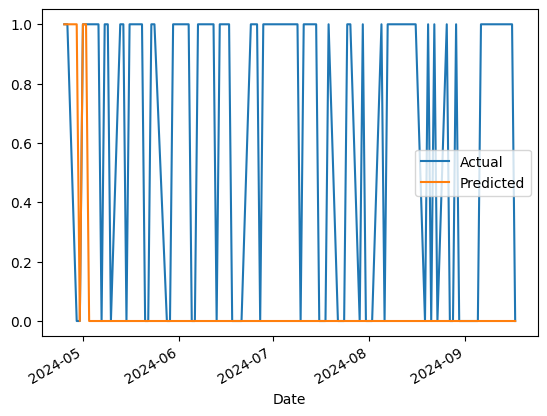

In [4]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()


model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100] #train set
test = sp500.iloc[-100:] #test set

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

#Now that the model is trained I am going to see how accurate it is.
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Target"], preds)
accuracy = accuracy_score(test["Target"], preds)

print(f"This model predicts whether the price of tomorrow's market will increase with {precision * 100:.2f}% precision")
print(f"Overall accuracy of the model: {accuracy * 100:.2f}%")

#when the model said the stock proce would go up it went up 80 percent of the time.

combined = pd.concat([test["Target"], preds], axis=1)
combined.columns = ["Actual", "Predicted"]
combined.plot()

# 100% precision but only 43% overall accuracy—suggests that the model is making very
# few positive predictions (predicting that the market will go up tomorrow), and when
# it does make these predictions, they are always correct. However, because the accuracy
# is only 43%, it means that the model is frequently predicting the market will go down,
# and this prediction is often incorrect.

##Backtesting system


In [5]:
# I want to be able to test across multiple years onsted of only the last 100 days
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined


def backtest(data, model, predictors, start=2500, step=250):
    # the start value is used in backtesting to have a certain amount of data to train the first model.
    # every year has about 250 days so I use 2500 to use the past 10 years of data. the step helps train 250 values (1 year) at a time.
    # so I am taking the first 10 years of data and predicting values for the 11th year. then I am taking the first 11 years of data and predicting values for the 12th and so on.
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

predictions = backtest(sp500, model, predictors)

# Error evaluation
temp_var = predictions["Predictions"].value_counts()
print(f"The model predicted the market would go up on {temp_var[1]} days and predicted it would go down on {temp_var[0]} days")
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"This model predicts whether the price of tomorrow's market will increase with {precision * 100:.2f}% precision")
temp_var = predictions["Target"].value_counts() / predictions.shape[0]
print(f"Given that the market actually went up {temp_var[1] * 100:.2f}, person x would have been better off just buying and selling everyday.\nHowever, this is okay because the backtesting system gives more confidence to our model")

The model predicted the market would go up on 2596 days and predicted it would go down on 3648 days
This model predicts whether the price of tomorrow's market will increase with 52.89% precision
This model predicts whether the price of tomorrow's market will increase with 52.89% precision
Given that the market actually went up 53.57, person x would have been better off just buying and selling everyday.
However, this is okay because the backtesting system gives more confidence to our model


##Adding Predictors

In [8]:
# Adding information such as change in market value from a week, month, 2 months ago etc.
horizons = [2,5,60,250,1000] # horazions on which to look at rolling means.
# calculate the mean closing price in the last 2 days. 5 (trading week), 60 (3 months), last year, last 4 years
# then I can find the ratio between todays closing price and the closing price in those periods and that will help the algorithm to make better predictions
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    # I will also use a trend. what this trend is going to do is on any given day, it will look at the past few days and see the sum of the target
    # what this means is that if we are on x date then it will look at the last y days and find the sum of the target
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]

# clean data
sp500 = sp500.dropna()

# updating model (changing number of estimators and parameters)
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
# also redefining predict method so that we can have more controll, right now it either returns a 0 or a 1
# I want to implement more controll over what becomes a 1 and what becomes a 0
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] # this returns a probability that the stock will go up or down ([:,1] gets the second column of preds which is the prob that we are talking about)
    preds[preds >= 0.6] = 1 # setting threshholds. so that the model only predicts the price will go up when it is more than 60% confident
    preds[preds < 0.6] = 0 # these threshholds just ask the model to be more confident before telling us weather the market will go up or down
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(sp500, model, new_predictors)
temp_var = predictions["Predictions"].value_counts()
print(f"The model predicted the market would go up on {temp_var[1]} days and predicted it would go down on {temp_var[0]} days")
precision = precision_score(predictions["Target"], predictions["Predictions"])
print(f"This model predicts whether the price of tomorrow's market will increase with {precision * 100:.2f}% precision")
temp_var = predictions["Target"].value_counts() / predictions.shape[0]
print(f"Now, given that the market actually went up {temp_var[1] * 100:.2f}, person x would be better using the model rather than buying and selling everyday")


The model predicted the market would go up on 480 days and predicted it would go down on 2763 days
This model predicts whether the price of tomorrow's market will increase with 51.46% precision
Now, given that the market actually went up 54.24, person x would be better using the model rather than buying and selling everyday
